# Sentence-Inference

### The problem is for every given pair of sentences ie. (sentence-1, sentence-2), determine if sentence-2 can be logically inferred given sentence-1.

## Importing libraries and data

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bs4 import BeautifulSoup
import re
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import sequence

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from difflib import SequenceMatcher

import re

from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
eng_stopwords = set(stopwords.words('english'))

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


### Importing Dataset

In [2]:
# reading training file with the data
df_train = pd.read_csv("data_set/train.csv")
df_train.head(10)

,gold_label,sentence1,sentence2
0,contradiction,A group of men with cowboy hats are watching a...,A group of women are watching a horse race
1,entailment,A kid with his head shaved sitting and holding...,Child sits with a cigarette.
2,neutral,A woman riding a bicycle past a car and a grou...,A woman riding a bicycle near a group of her f...
3,neutral,A woman looking through what appears to be a t...,An female astronamer looking toward the stars ...
4,entailment,A large group of people stand outside on a roa...,One group of people are watching what another ...
5,contradiction,A small dark-haired boy climbing in a large tree.,A small dark-haired boy is climbing over a car...
6,neutral,A man sits beside parked cars on a city street.,A man is sitting on a bench.
7,entailment,A dog looks content sitting on a bed after rip...,a dog sitting on a bed after ripping up paper.
8,contradiction,Young children and parents splashing around a ...,There are families eating lunch
9,entailment,A football coach guiding one of his players on...,The coach knows how to play football.


In [3]:
df_test = pd.read_csv("data_set/test.csv")
df_test.head()

,sentence1,sentence2
0,Number 13 kicks a soccer ball towards the goal...,A player fighting in a soccer game.
1,A woman walks next to a subway exit.,A woman is on here way home.
2,A man walks down the alley talking on his cell...,A man is walking down a wooded path and talkin...
3,Indian women playing musical chairs with white...,indain woman playing cricket with white woman
4,An older perhaps Asian man who is wearing a sl...,A tall human wearing


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9349 entries, 0 to 9348
Data columns (total 3 columns):
gold_label    9349 non-null object
sentence1     9349 non-null object
sentence2     9349 non-null object
dtypes: object(3)
memory usage: 219.2+ KB


In [5]:
df_train.shape

(9349, 3)

In [6]:
# checking if there any missing value in the dataset
df_train.isna().any()

gold_label    False
sentence1     False
sentence2     False
dtype: bool

In [7]:
# checking the total number of classes for the target variable
df_train.gold_label.value_counts()

entailment       3166
contradiction    3114
neutral          3069
Name: gold_label, dtype: int64

### NOTE: the data seems to be balanced with no missing values. <br> Now, I can proceed with data cleaning. 

## Cleaning Data 

In [8]:
# I have used a custom list of stop words which do not have exceptional strings like 'no', 'nor', 'not'
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [9]:
def decontracted(phrase):
    '''
     Here is this function I will replace the words which has short hand representation of two words added together, 
     like won't is represtative of would not, etc. to the full hand representations of them.
    '''
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
def clean_text(sentance):
    '''
    Here is this function I will clean the data by following the steps:
    * remove the hyperlinks like http://...
    * Remove the HTML and XML tags using BeautifulSoup library.
    * removing white spaces and numerical values.
    * keeping only ascii characters.
    * and finally removing all stopwords from the text and making all characters to lowercase.
    '''
    
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    return sentance.strip()

In [11]:
# data before cleaning
df_train.head(10)

,gold_label,sentence1,sentence2
0,contradiction,A group of men with cowboy hats are watching a...,A group of women are watching a horse race
1,entailment,A kid with his head shaved sitting and holding...,Child sits with a cigarette.
2,neutral,A woman riding a bicycle past a car and a grou...,A woman riding a bicycle near a group of her f...
3,neutral,A woman looking through what appears to be a t...,An female astronamer looking toward the stars ...
4,entailment,A large group of people stand outside on a roa...,One group of people are watching what another ...
5,contradiction,A small dark-haired boy climbing in a large tree.,A small dark-haired boy is climbing over a car...
6,neutral,A man sits beside parked cars on a city street.,A man is sitting on a bench.
7,entailment,A dog looks content sitting on a bed after rip...,a dog sitting on a bed after ripping up paper.
8,contradiction,Young children and parents splashing around a ...,There are families eating lunch
9,entailment,A football coach guiding one of his players on...,The coach knows how to play football.


In [12]:
preprocessed_sentence1 = []
preprocessed_sentence2 = []

for i in tqdm(range(len(df_train)), position=0, leave=True):
    df_train.sentence1[i] = clean_text(df_train.sentence1[i])
    df_train.sentence2[i] = clean_text(df_train.sentence2[i])
    preprocessed_sentence1.append(df_train.sentence1[i])
    preprocessed_sentence2.append(df_train.sentence2[i])

100%|█████████████████████████████████████████████████████████████████████████████| 9349/9349 [00:11<00:00, 806.27it/s]


In [13]:
for i in tqdm(range(len(df_test)), position=0, leave=True):
    df_test.sentence1[i] = clean_text(df_test.sentence1[i])
    df_test.sentence2[i] = clean_text(df_test.sentence2[i])

100%|███████████████████████████████████████████████████████████████████████████████| 493/493 [00:00<00:00, 830.42it/s]


In [14]:
# this is how the clean processed data looks
preprocessed_sentence1[:10]

['group men cowboy hats watching rodeo',
 'kid head shaved sitting holding lit cigarette',
 'woman riding bicycle past car group people sidewalk',
 'woman looking appears telescope',
 'large group people stand outside road people higher level look',
 'small dark haired boy climbing large tree',
 'man sits beside parked cars city street',
 'dog looks content sitting bed ripping paper',
 'young children parents splashing around public fountain',
 'football coach guiding one players']

In [15]:
# data after cleaning
df_train.head(10)

,gold_label,sentence1,sentence2
0,contradiction,group men cowboy hats watching rodeo,group women watching horse race
1,entailment,kid head shaved sitting holding lit cigarette,child sits cigarette
2,neutral,woman riding bicycle past car group people sid...,woman riding bicycle near group friends sidewalk
3,neutral,woman looking appears telescope,female astronamer looking toward stars telescope
4,entailment,large group people stand outside road people h...,one group people watching another group
5,contradiction,small dark haired boy climbing large tree,small dark haired boy climbing car seat
6,neutral,man sits beside parked cars city street,man sitting bench
7,entailment,dog looks content sitting bed ripping paper,dog sitting bed ripping paper
8,contradiction,young children parents splashing around public...,families eating lunch
9,entailment,football coach guiding one players,coach knows play football


In [16]:
# converting the gold_label column into a categorical column
df_train['gold_label'] = df_train['gold_label'].astype('category')

In [17]:
# converting the gold_label column into numerical values using LabelEncoder
encoder = LabelEncoder()
df_train['gold_label_encoded'] = encoder.fit_transform(df_train['gold_label'])
df_train.head(10)

,gold_label,sentence1,sentence2,gold_label_encoded
0,contradiction,group men cowboy hats watching rodeo,group women watching horse race,0
1,entailment,kid head shaved sitting holding lit cigarette,child sits cigarette,1
2,neutral,woman riding bicycle past car group people sid...,woman riding bicycle near group friends sidewalk,2
3,neutral,woman looking appears telescope,female astronamer looking toward stars telescope,2
4,entailment,large group people stand outside road people h...,one group people watching another group,1
5,contradiction,small dark haired boy climbing large tree,small dark haired boy climbing car seat,0
6,neutral,man sits beside parked cars city street,man sitting bench,2
7,entailment,dog looks content sitting bed ripping paper,dog sitting bed ripping paper,1
8,contradiction,young children parents splashing around public...,families eating lunch,0
9,entailment,football coach guiding one players,coach knows play football,1


## Data Visualization

In [18]:
# this cell shows the average length of words in each sentence
avg_length_s1 = df_train['sentence1'].apply(lambda x: len(x.split(" "))).mean()
avg_length_s2 = df_train['sentence2'].apply(lambda x: len(x.split(" "))).mean()
print("Average Length of sentence 1: ", avg_length_s1)
print("Average Length of sentence 2: ", avg_length_s2)

Average Length of sentence 1:  7.985239063001391
Average Length of sentence 2:  4.091774521339181


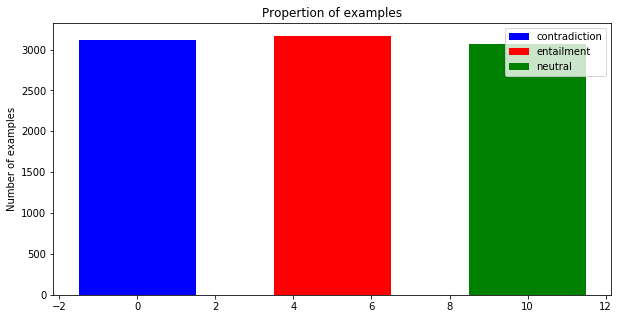

In [19]:
# this plot shows that the data is balanced and all the three categories have very similar number of examples.
contradiction_len = df_train[df_train['gold_label'] == 'contradiction'].shape[0]
entailment_len = df_train[df_train['gold_label'] == 'entailment'].shape[0]
neutral_len = df_train[df_train['gold_label'] == 'neutral'].shape[0]

plt.rcParams['figure.figsize'] = (10, 5)
plt.bar(0,contradiction_len,3, label="contradiction", color='blue')
plt.bar(5,entailment_len,3, label="entailment", color='red')
plt.bar(10,neutral_len,3, label="neutral", color='green')

plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [20]:
def length(text):
    '''
    function to calculate length of a series
    '''
    return len(text)

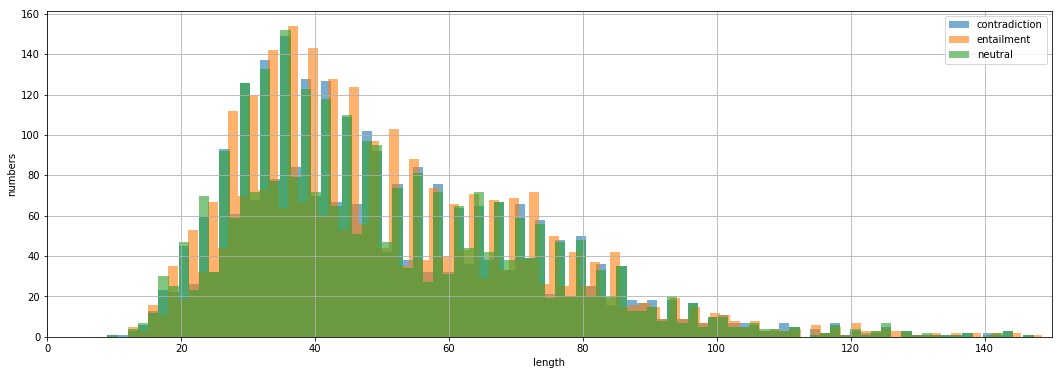

In [21]:
# Here I am creating the length_s1 column for the training and testing datasets which contains the length of sentence1
df_train['length_s1'] = df_train['sentence1'] .apply(length)
df_test['length_s1'] = df_test['sentence1'] .apply(length)

# Here I am plotting the above created column for all the three categories of the gold_label column
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df_train[df_train['gold_label'] == 'contradiction']['length_s1'], alpha = 0.6, bins=bins, label='contradiction')
plt.hist(df_train[df_train['gold_label'] == 'entailment']['length_s1'], alpha = 0.6, bins=bins, label='entailment')
plt.hist(df_train[df_train['gold_label'] == 'neutral']['length_s1'], alpha = 0.6, bins=bins, label='neutral')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.savefig('./images/length_of_doc_s1.png')
plt.show()

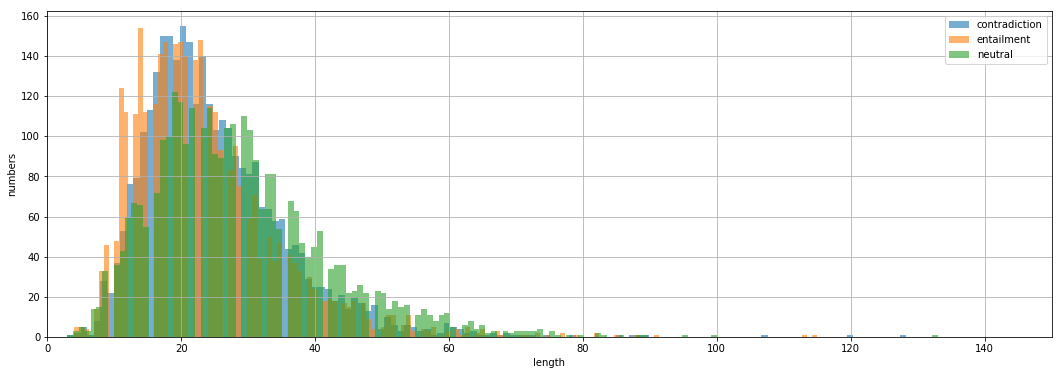

In [22]:
# Here I am creating the length_s2 column for the training and testing datasets which contains the length of sentence2

df_train['length_s2'] = df_train['sentence2'] .apply(length)
df_test['length_s2'] = df_test['sentence2'] .apply(length)

# Here I am plotting the above created column for all the three categories of the gold_label column
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df_train[df_train['gold_label'] == 'contradiction']['length_s2'], alpha = 0.6, bins=bins, label='contradiction')
plt.hist(df_train[df_train['gold_label'] == 'entailment']['length_s2'], alpha = 0.6, bins=bins, label='entailment')
plt.hist(df_train[df_train['gold_label'] == 'neutral']['length_s2'], alpha = 0.6, bins=bins, label='neutral')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.savefig('./images/length_of_doc_s2.png')
plt.show()

<hr>

## Feature Engineering

In [23]:
def seq_similarity(a, b):
    '''this function calculate the similarity between two strings using sequence matcher'''
    return SequenceMatcher(None, a, b).ratio()
    
def seq_match_df(df_data):
    '''this function will apply the seq_similarity on the dataset passed as parameter for both sentences'''
    col1 = 'sentence1'
    col2 = 'sentence2'
    df_data[col1] = df_data[col1].str.replace(r'\d', '')
    df_data[col2] = df_data[col2].str.replace(r'\d', '')
    df_data['seq_sim'] = 0
    df_data['seq_sim'] = df_data.apply(lambda x: seq_similarity(x[col1], x[col2]), axis=1)
    return df_data

# applying the sequence matching on the training and testing datasets
df_train_result_seq = seq_match_df(df_train)
df_test_result_seq = seq_match_df(df_test)

In [24]:
vectorizer = text.TfidfVectorizer()

def cosine_sim(test1, test2):
    '''this function calculate the cosine similarity between two strings 
    using Term frequency and Inverse document frequency vector'''
    tfidf = vectorizer.fit_transform([test1, test2])
    result = ((tfidf * tfidf.T).A)[0,1]
    return result
    
def cosine_sim_df(df_data):
    '''this function will apply the cosine_sim on the dataset passed as parameter for both sentences'''
    col1 = 'sentence1'
    col2 = 'sentence2'
    df_data[col1] = df_data[col1].str.replace(r'\d', '')
    df_data[col2] = df_data[col2].str.replace(r'\d', '')
    df_data['cos_sim'] = 0
    df_data['cos_sim'] = df_data.apply(lambda x: cosine_sim(x[col1], x[col2]), axis=1)
    return df_data

# applying the cosine similarity on the training and testing datasets
df_train_result_cos = cosine_sim_df(df_train)
df_test_result_cos = cosine_sim_df(df_test)

### Unigram

In [25]:

def get_unigrams(que):
    '''this function will generat the unigram for a string'''
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]


# Here I am applying the above function to get unigrams for sentence1 and sentence2
df_train["unigrams_s1"] = df_train['sentence1'].apply(lambda x: get_unigrams(str(x)))
df_train["unigrams_s2"] = df_train['sentence2'].apply(lambda x: get_unigrams(str(x)))
df_test["unigrams_s1"] = df_test['sentence1'].apply(lambda x: get_unigrams(str(x)))
df_test["unigrams_s2"] = df_test['sentence2'].apply(lambda x: get_unigrams(str(x)))

In [26]:
def get_common_unigrams(row):
    '''this function finds the intersection between two unigrams in pandas and return length of intersection'''
    return len(set(row["unigrams_s1"]).intersection(set(row["unigrams_s2"])) ) 

# Here I am applying the above function to get unique unigrams
df_train["unigrams_common_count"] = df_train.apply(lambda row: get_common_unigrams(row), axis=1)
df_test["unigrams_common_count"] = df_test.apply(lambda row: get_common_unigrams(row), axis=1)

In [27]:
def get_common_unigram_ratio(row):
    '''this function will genetate the ratio of common unigrams to the maximum of union of the two sets'''
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_s1"]).union(set(row["unigrams_s2"]))), 1)

# Here I am applying the above function to get unique unigrams ratio
df_train["unigrams_common_ratio"] = df_train.apply(lambda row: get_common_unigram_ratio(row),axis=1)
df_test["unigrams_common_ratio"] = df_test.apply(lambda row: get_common_unigram_ratio(row),axis=1)

### Bigram

In [28]:
def get_bigrams(que):
    '''this function creates the bigram for a string'''
    return [ i for i in ngrams(que,2)]

# Here I am applying the above function to get bigrams for sentence1 and sentence2
df_train["bigrams_s1"] = df_train["unigrams_s1"].apply(lambda x: get_bigrams(x))
df_train["bigrams_s2"] = df_train["unigrams_s2"].apply(lambda x: get_bigrams(x))
df_test["bigrams_s1"] = df_test["unigrams_s1"].apply(lambda x: get_bigrams(x))
df_test["bigrams_s2"] = df_test["unigrams_s2"].apply(lambda x: get_bigrams(x))

In [29]:
def get_common_bigrams(row):
    '''this function finds the intersection between two bigrams in pandas and return length of intersection'''
    return len( set(row['bigrams_s1']).intersection(set(row['bigrams_s2'])) )

# Here I am applying the above function to get unique bigrams
df_train["bigrams_common_count"] = df_train.apply(lambda row: get_common_bigrams(row), axis=1)
df_test["bigrams_common_count"] = df_test.apply(lambda row: get_common_bigrams(row), axis=1)

In [30]:
def get_common_bigram_ratio(row):
    '''this function will genetate the ratio of common bigrams to the maximum of union of the two sets'''
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_s1"]).union(set(row["bigrams_s2"]))), 1)

# Here I am applying the above function to get unique bigrams ratio
df_train["bigrams_common_ratio"] = df_train.apply(lambda row: get_common_bigram_ratio(row), axis=1)
df_test["bigrams_common_ratio"] = df_test.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [31]:
# train_data_features_2 = vectorizer.fit_transform(X_train["sentence2"])
# train_data_features_2 = train_data_features_2.toarray()
# print(train_data_features_2.shape)

# train_data_features_1 = vectorizer.fit_transform(X_train['sentence1'])
# train_data_features_1 = train_data_features_1.toarray()
# print(train_data_features_1.shape)

# train_data_features_12 = np.stack((train_data_features_1, train_data_features_2), axis=0) 
# print(train_data_features_12.shape)

# train_data_features_12 = train_data_features_12.reshape(train_data_features_1.shape[0], -1)
# print(train_data_features_12.shape)

In [32]:
# test_data_features_2 = vectorizer.fit_transform(X_test["sentence2"])
# test_data_features_2 = test_data_features_2.toarray()
# print(test_data_features_2.shape)

# test_data_features_1 = vectorizer.fit_transform(X_test['sentence1'])
# test_data_features_1 = test_data_features_1.toarray()
# print(test_data_features_1.shape)

# test_data_features_12 = np.stack((test_data_features_1, test_data_features_2), axis=0) 
# print(test_data_features_12.shape)

# test_data_features_12 = test_data_features_12.reshape(test_data_features_1.shape[0], -1)
# print(test_data_features_12.shape)

In [33]:
# vocab = vectorizer.get_feature_names()
# print(vocab)

In [34]:
df_train.head(3)

,gold_label,sentence1,sentence2,gold_label_encoded,length_s1,length_s2,seq_sim,cos_sim,unigrams_s1,unigrams_s2,unigrams_common_count,unigrams_common_ratio,bigrams_s1,bigrams_s2,bigrams_common_count,bigrams_common_ratio
0,contradiction,group men cowboy hats watching rodeo,group women watching horse race,0,36,31,0.626866,0.225765,"[group, men, cowboy, hats, watching, rodeo]","[group, women, watching, horse, race]",2,0.222222,"[(group, men), (men, cowboy), (cowboy, hats), ...","[(group, women), (women, watching), (watching,...",0,0.000000
1,entailment,kid head shaved sitting holding lit cigarette,child sits cigarette,1,45,20,0.492308,0.125367,"[kid, head, shaved, sitting, holding, lit, cig...","[child, sits, cigarette]",1,0.111111,"[(kid, head), (head, shaved), (shaved, sitting...","[(child, sits), (sits, cigarette)]",0,0.000000
2,neutral,woman riding bicycle past car group people sid...,woman riding bicycle near group friends sidewalk,2,51,48,0.808081,0.505606,"[woman, riding, bicycle, past, car, group, peo...","[woman, riding, bicycle, near, group, friends,...",5,0.500000,"[(woman, riding), (riding, bicycle), (bicycle,...","[(woman, riding), (riding, bicycle), (bicycle,...",2,0.181818


In [35]:
# Here I am removing the object columns from the dataset and creating the input and target datasets for training
df_X = df_train.drop(['gold_label', 'sentence1', 'sentence2', 'unigrams_s1',
                      'unigrams_s2', 'bigrams_s1', 'bigrams_s2', 'gold_label_encoded'], axis=1)
df_y = df_train["gold_label_encoded"]

In [36]:
# Here I am removing the object columns from the test dataset and creating the input dataset for testing
df_test_X = df_test.drop(['sentence1', 'sentence2', 'unigrams_s1',
                      'unigrams_s2', 'bigrams_s1', 'bigrams_s2'], axis=1)

In [37]:
df_X.head(3)

,length_s1,length_s2,seq_sim,cos_sim,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio
0,36,31,0.626866,0.225765,2,0.222222,0,0.000000
1,45,20,0.492308,0.125367,1,0.111111,0,0.000000
2,51,48,0.808081,0.505606,5,0.500000,2,0.181818


In [38]:
df_test_X.head(3)

,length_s1,length_s2,seq_sim,cos_sim,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio
0,58,27,0.423529,0.299580,2,0.200000,1,0.1
1,28,14,0.523810,0.150640,1,0.142857,0,0.0
2,33,37,0.685714,0.225765,2,0.222222,0,0.0


### Plotting the correlation

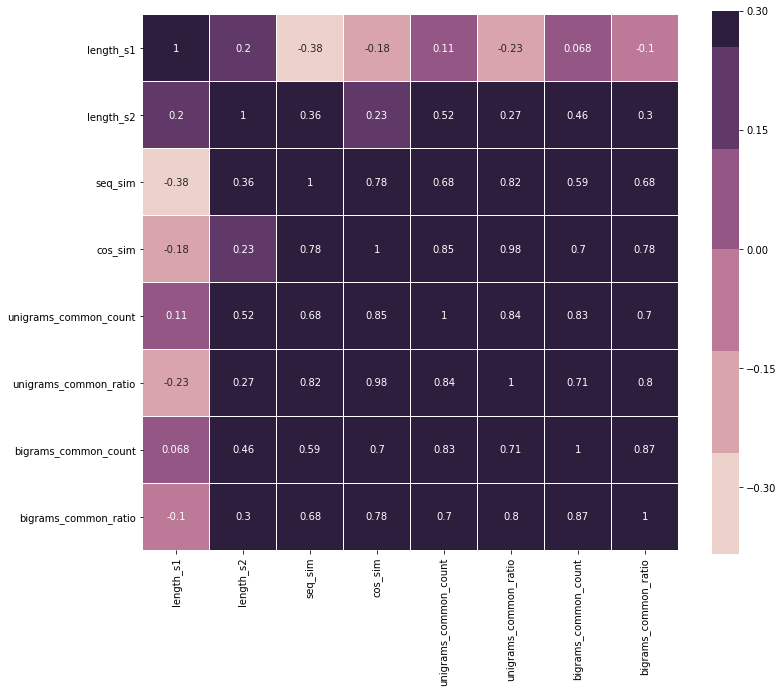

In [39]:
# here I am plotting the heatmap based on the correlation matrix of features in the dataset. 
df_X.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_X.corr(), annot=True, linewidths=0.5, square=True, vmax=0.3, center=0, cmap=sns.cubehelix_palette())
plt.savefig('./images/correlation_heatmap.png')

### Scaling Data

In [40]:
# In this cell I am scaling the complete input dataset using MinMaxScaler 
# which will fit the data in the range of inclusive [0, 1]
# fitting the training input data and transforming both training and testing data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_X)
df_test_scaled = scaler.transform(df_test_X)
print(df_scaled)
print(df_test_scaled)

[[0.11842105 0.18918919 0.61765248 ... 0.22222222 0.         0.        ]
 [0.15789474 0.11486486 0.47977208 ... 0.11111111 0.         0.        ]
 [0.18421053 0.30405405 0.80334206 ... 0.5        0.08333333 0.18181818]
 ...
 [0.29385965 0.23648649 0.42473468 ... 0.13333333 0.         0.        ]
 [0.11842105 0.25675676 0.5342312  ... 0.3        0.04166667 0.1       ]
 [0.18859649 0.35135135 0.93296412 ... 0.77777778 0.20833333 0.55555556]]
[[0.21491228 0.16216216 0.40929557 ... 0.2        0.04166667 0.1       ]
 [0.08333333 0.07432432 0.51205173 ... 0.14285714 0.         0.        ]
 [0.10526316 0.22972973 0.67795414 ... 0.22222222 0.         0.        ]
 ...
 [0.22368421 0.14189189 0.24368019 ... 0.         0.         0.        ]
 [0.19298246 0.10135135 0.14849591 ... 0.         0.         0.        ]
 [0.1754386  0.16891892 0.5342312  ... 0.375      0.04166667 0.125     ]]


In [41]:
# Here I am splitting the trainign data into train and validation datasets in a ratio of 80:20 percentage.
X_train, X_cv, y_train, y_cv = train_test_split(df_scaled, df_y, test_size=0.2, random_state=42)
X_train.shape

(7479, 8)

## Building ML Models

In [42]:
def model_evaluation(y_test, y_pred):
    '''
    this function will claculate the evaluation matrix for the real output and predicted output values and generate report for:
    * Confusion Matrix
    * Matrics like True Positive, True Negative, False Positive and False Negative
    * Calculate accuracy based on the above factors
    * generate classification report
    '''
    cm = confusion_matrix(y_test, y_pred)

    print("Confusion Matrix:")
    print(cm, end="\n\n")

    TN = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TP = cm[1, 1]

    P = FN+TP
    N = TN+FP

    TPR = TP/P
    TNR = TN/N
    FPR = FP/N
    FNR = FN/P

    accuracy = (TN+TP)/(P+N)
#     print("Test Accuracy: "+str(accuracy), end="\n\n")
    print("Test Accuracy: "+str(accuracy_score(y_test, y_pred)), end="\n\n")
    print("All 4 parameters: ",TN, FN, FP, TP, end="\n\n")
    print("TPR: {}".format(TPR))
    print("TNR: {}".format(TNR))
    print("FPR: {}".format(FPR))
    print("FNR: {}".format(FNR))
    print()
    
    print(classification_report(y_test, y_pred))

#### Classification models

In [43]:
# Here I am making a list of some high performing classification machine learnign models 
# and over each iteration I am printing their performance for 3 cross validations.

models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("SVC",SVC()))

for name,model in models:
    kfold = KFold(n_splits=3, random_state=42)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result, np.mean(cv_result))

LR [0.49298034 0.48215002 0.52667469] 0.5006016847172082
NB [0.44925792 0.44003209 0.45166466] 0.44698489102821237
RF [0.44685118 0.45527477 0.4713197 ] 0.4578152159379596
Dtree [0.42438829 0.40593662 0.42198155] 0.41743548602754377
XGB [0.50300842 0.49578821 0.53269154] 0.5104960556224094
KNN [0.46048937 0.459286   0.47412756] 0.46463430939965233
SVC [0.49177698 0.48054553 0.50701966] 0.4931140526808397


#### XGB Classifier

In [44]:
# Based on the performance analysis of the above models I am selecting XGBClassifier
# Here I am training the XGBClassifier using training dataset and validating the matrics using validation dataset.
# finally I am generating the performance report of the model.

xgb_classifier = xgb.XGBClassifier()
hist = xgb_classifier.fit(X_train, y_train)
predictions = xgb_classifier.predict(X_cv)
print("prediction: ", predictions, end="\n\n")
model_evaluation(y_cv, predictions)

prediction:  [1 2 1 ... 0 0 0]

Confusion Matrix:
[[380 110 125]
 [151 396  90]
 [269 129 220]]

Test Accuracy: 0.532620320855615

All 4 parameters:  380 110 151 396

TPR: 0.782608695652174
TNR: 0.7156308851224106
FPR: 0.2843691148775895
FNR: 0.21739130434782608

              precision    recall  f1-score   support

           0       0.47      0.62      0.54       615
           1       0.62      0.62      0.62       637
           2       0.51      0.36      0.42       618

   micro avg       0.53      0.53      0.53      1870
   macro avg       0.53      0.53      0.53      1870
weighted avg       0.54      0.53      0.53      1870



### Working on Neural Network

In [45]:
def show_learning_curve(hist, fig_name):
    '''
    this function will plot the graph showing the network's performance on training data 
    and plots metrics like loss, val_loss, accuracy, val_accuracy.
    '''
    plt.plot(hist.history['loss'], 'y', label='train loss')
    plt.plot(hist.history['val_loss'], 'r', label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower left')
    plt.savefig(f'./images/{fig_name}_loss.png')
    plt.show()
    
    plt.plot(hist.history['accuracy'], 'b', label='train acc')
    plt.plot(hist.history['val_accuracy'], 'g', label='val acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='upper left')
    plt.savefig(f'./images/{fig_name}_accuracy.png')
    plt.show()


#### Multi-layer Perceptron

In [46]:
# Here I am training the Multi Layer Perceptron Classifier which is available in sklearn library
# using training dataset and validating the matrics using validation dataset.
# finally I am generating the performance report of the model.

from sklearn.neural_network import MLPClassifier
mpl_model = MLPClassifier(hidden_layer_sizes=(20,90,120), learning_rate_init=0.001, max_iter=5000)
mpl_model.fit(X_train, y_train)
predictions = mpl_model.predict(X_cv)

model_evaluation(y_cv, predictions)

Confusion Matrix:
[[420 103  92]
 [178 393  66]
 [302 129 187]]

Test Accuracy: 0.5347593582887701

All 4 parameters:  420 103 178 393

TPR: 0.7923387096774194
TNR: 0.7023411371237458
FPR: 0.2976588628762542
FNR: 0.20766129032258066

              precision    recall  f1-score   support

           0       0.47      0.68      0.55       615
           1       0.63      0.62      0.62       637
           2       0.54      0.30      0.39       618

   micro avg       0.53      0.53      0.53      1870
   macro avg       0.55      0.53      0.52      1870
weighted avg       0.55      0.53      0.52      1870



#### Sequential Network

In [47]:
# Here I am buiding a simple sequential 3 layer ANN with a dropout of 0.1 and running over 100 epocs for 50 batch size
# parallely measuring the validation score for 20% of data.

inp = len(df_X.columns)
classifier = Sequential()
classifier.add(Dense(units = inp, kernel_initializer = 'uniform', activation = 'relu', input_dim = df_X.shape[1]))
classifier.add(Dropout(0.1))
classifier.add(Dense(units = inp*2, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(units = inp*3, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'RMSProp', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_hist = classifier.fit(df_X, df_y, batch_size = 50, epochs = 100, validation_split=0.2)
print(model_hist.history)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7479 samples, validate on 1870 samples
Epoch 1/100
7479/7479 [==============================] - 0s 56us/step - loss: 0.1337 - accuracy: 0.3406 - val_loss: -0.2905 - val_accuracy: 0.3353
Epoch 2/100
7479/7479 [==============================] - 0s 30us/step - loss: -0.1385 - accuracy: 0.3395 - val_loss: -0.6079 - val_accuracy: 0.3353
Epoch 3/100
7479/7479 [==============================] - 0s 31us/step - loss: -0.3486 - accuracy: 0.3395 - val_loss: -1.1801 - val_accuracy: 0.3353
Epoch 4/100
7479/7479 [==============================] - 0s 33us/step - loss: -0.7570 - accuracy: 0.3395 - val_loss: -2.4105 - val_accuracy: 0.3353
Epoch 5/100
7479/7479 [==============================] - 0s 31us/step - loss: -1.4580 - accuracy: 0.3395 - val_loss: -4.3123 - val_accuracy: 0.3353
Epoch 6/100
7479/7479 [==============

7479/7479 [==============================] - 0s 33us/step - loss: -48711.1262 - accuracy: 0.3403 - val_loss: -80855.2690 - val_accuracy: 0.3353
Epoch 49/100
7479/7479 [==============================] - 0s 34us/step - loss: -54041.6844 - accuracy: 0.3402 - val_loss: -88430.1585 - val_accuracy: 0.3353
Epoch 50/100
7479/7479 [==============================] - 0s 33us/step - loss: -59480.0043 - accuracy: 0.3394 - val_loss: -95892.7251 - val_accuracy: 0.3353
Epoch 51/100
7479/7479 [==============================] - 0s 34us/step - loss: -65786.1693 - accuracy: 0.3391 - val_loss: -104531.9721 - val_accuracy: 0.3353
Epoch 52/100
7479/7479 [==============================] - 0s 30us/step - loss: -65816.7288 - accuracy: 0.3399 - val_loss: -112687.4018 - val_accuracy: 0.3353
Epoch 53/100
7479/7479 [==============================] - 0s 29us/step - loss: -71397.6967 - accuracy: 0.3391 - val_loss: -121512.3111 - val_accuracy: 0.3353
Epoch 54/100
7479/7479 [==============================] - 0s 32us/st

7479/7479 [==============================] - 0s 31us/step - loss: -1058389.1367 - accuracy: 0.3404 - val_loss: -1692679.2524 - val_accuracy: 0.3353
Epoch 100/100
7479/7479 [==============================] - 0s 29us/step - loss: -1126742.9720 - accuracy: 0.3398 - val_loss: -1764555.8211 - val_accuracy: 0.3353
{'val_loss': [-0.2904539117440183, -0.6078656224962224, -1.1800640932817192, -2.4104530288773107, -4.312272385639303, -8.780329867799015, -15.640267057852311, -27.365990292898474, -44.197142787795656, -69.38446962642159, -104.21902398247133, -160.8608177205458, -226.88784626078478, -307.4179328367672, -423.94574342564465, -564.4681044058366, -741.2042131347453, -953.7371183487184, -1233.458542288306, -1580.1997732478667, -1941.5534286295028, -2398.8472941597515, -2978.3250245690983, -3629.3949579249092, -4366.988407889789, -5181.210149102032, -6202.045590732187, -7332.120653448258, -8742.421630696179, -10122.947744767296, -11759.087386676973, -13526.0146781391, -15385.36402313722, 

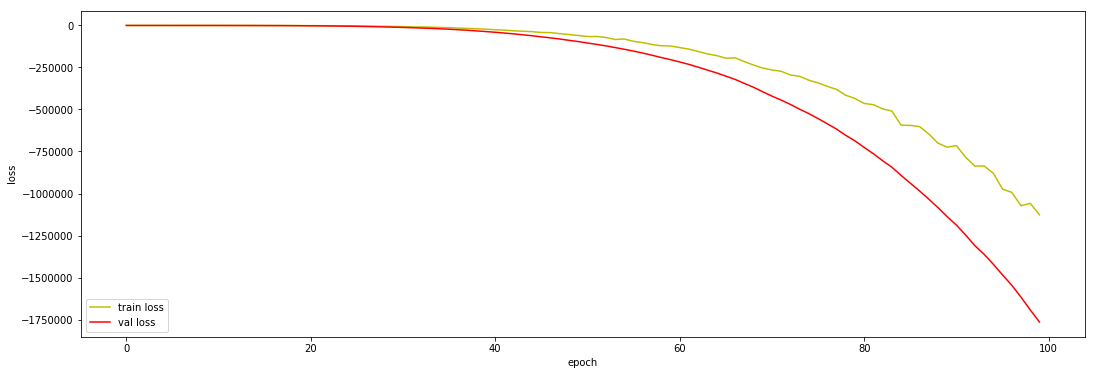

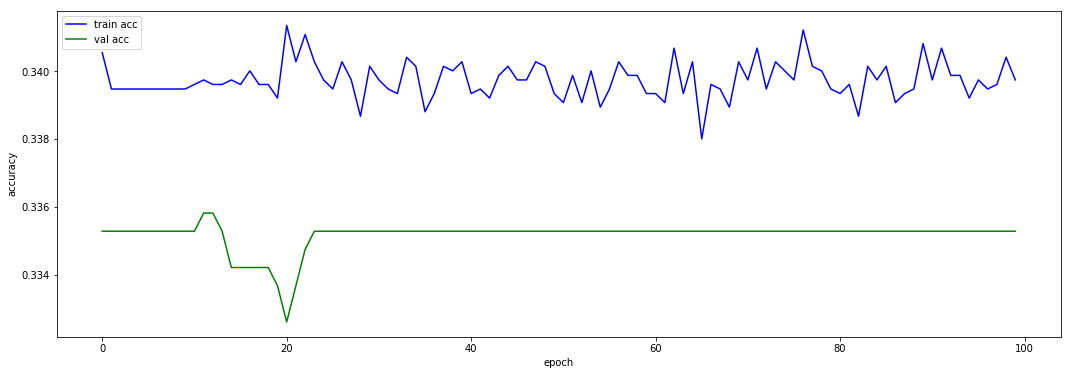

In [48]:
# here I am plotting the curves for training and testing performance based on model's history.
# evaluating the accuracy for train and val, and loss for train and val data.
show_learning_curve(model_hist, 'sequential_model_performance')

#### Bidirectional LSTM Network

In [49]:
# Here I am buiding a Sequential Bidirectional LSTM ANN  with an input embedding layer of (2000, 128)
# and running over 100 epocs for 50 batch size
# parallely measuring the validation score for 20% of data.

model = Sequential()
model.add(Embedding(2000, 128))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
# model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_hist = model.fit(df_X, df_y, batch_size=50, epochs=100, validation_split=0.2)
print(model_hist.history)

Train on 7479 samples, validate on 1870 samples
Epoch 1/100
7479/7479 [==============================] - 2s 304us/step - loss: 0.1303 - accuracy: 0.3389 - val_loss: -0.0645 - val_accuracy: 0.3353
Epoch 2/100
7479/7479 [==============================] - 2s 233us/step - loss: 0.0228 - accuracy: 0.3395 - val_loss: -0.2622 - val_accuracy: 0.3353
Epoch 3/100
7479/7479 [==============================] - 2s 234us/step - loss: -0.6392 - accuracy: 0.3395 - val_loss: -1.4899 - val_accuracy: 0.3353
Epoch 4/100
7479/7479 [==============================] - 2s 234us/step - loss: -2.2252 - accuracy: 0.3395 - val_loss: -3.9997 - val_accuracy: 0.3353
Epoch 5/100
7479/7479 [==============================] - 2s 239us/step - loss: -4.5819 - accuracy: 0.3395 - val_loss: -7.1957 - val_accuracy: 0.3353
Epoch 6/100
7479/7479 [==============================] - 2s 233us/step - loss: -8.3715 - accuracy: 0.3395 - val_loss: -12.6719 - val_accuracy: 0.3353
Epoch 7/100
7479/7479 [==============================] - 2s

7479/7479 [==============================] - 2s 231us/step - loss: -1372.5139 - accuracy: 0.3581 - val_loss: -1061.7733 - val_accuracy: 0.3476
Epoch 55/100
7479/7479 [==============================] - 2s 226us/step - loss: -1411.6715 - accuracy: 0.3579 - val_loss: -1135.4168 - val_accuracy: 0.3396
Epoch 56/100
7479/7479 [==============================] - 2s 223us/step - loss: -1459.2419 - accuracy: 0.3586 - val_loss: -1134.8482 - val_accuracy: 0.3412
Epoch 57/100
7479/7479 [==============================] - 2s 223us/step - loss: -1525.3593 - accuracy: 0.3573 - val_loss: -1157.7455 - val_accuracy: 0.3455
Epoch 58/100
7479/7479 [==============================] - 2s 225us/step - loss: -1586.2732 - accuracy: 0.3554 - val_loss: -1198.8291 - val_accuracy: 0.3481
Epoch 59/100
7479/7479 [==============================] - 2s 225us/step - loss: -1654.6110 - accuracy: 0.3585 - val_loss: -1222.8994 - val_accuracy: 0.3476
Epoch 60/100
7479/7479 [==============================] - 2s 226us/step - los

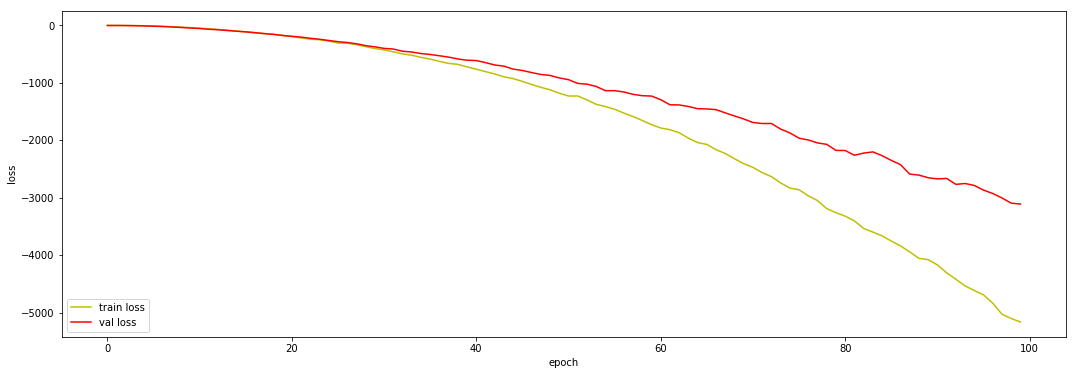

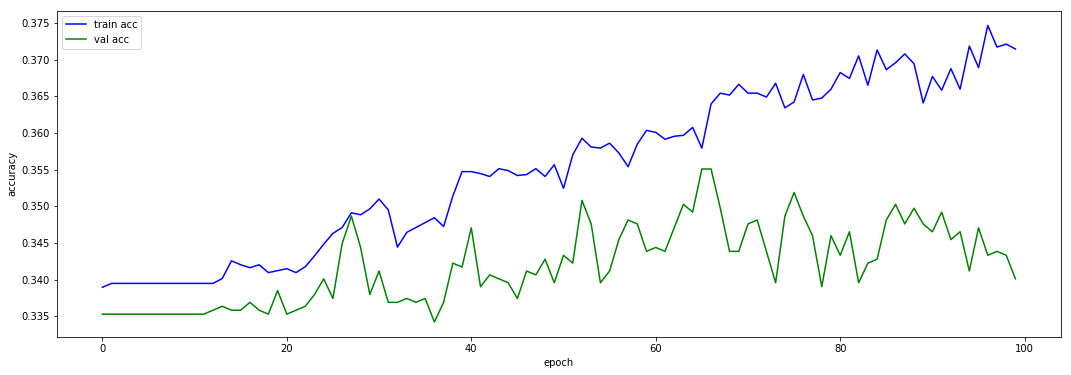

In [50]:
# here I am plotting the curves for training and testing performance based on model's history.
# evaluating the accuracy for train and val, and loss for train and val data.
show_learning_curve(model_hist, 'bidirectional_LSTM_model_performance')

### NOTE: <br>Neural networks are not able to perform well on the data as the quantuty of data is very less and for a ANN to train, and I found XGBoost and MLPClassifier to perform pretty well as compared to other models, so I will be using MLPClassifier for predicting the final result for the test data.


## Predicting gold_label for test data

In [51]:
# Here I am predicting the output for the test dataset using the Multilayer perceptron model
test_prediction = mpl_model.predict(df_test_scaled)
print(test_prediction)

[2 1 2 1 0 2 0 0 0 2 1 2 1 0 0 1 1 1 0 1 0 0 0 1 0 1 2 0 1 0 1 0 2 1 1 1 0
 1 0 0 0 2 0 2 0 0 0 1 1 0 2 2 0 2 1 0 0 0 2 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 2 1 2 0 2 0 1 0 0 0 0 0 0 0 1 2 1 2 2 1 0 0 2 1 0
 1 0 0 2 1 0 0 0 1 0 1 1 0 2 0 0 0 1 2 2 0 2 2 1 0 1 0 0 2 0 0 1 0 0 2 1 2
 1 1 0 1 0 0 0 2 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 2 1 0 0 2 0 1 1 1 0 2 1 1
 1 1 0 1 0 1 1 0 0 2 0 2 0 0 0 0 1 1 0 1 1 2 0 0 1 0 1 0 0 0 1 0 1 0 1 2 2
 0 0 1 0 0 1 2 2 1 1 2 0 1 0 1 0 2 0 1 0 1 1 1 0 0 0 1 0 1 2 1 2 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 2 2 1 0 0 1 0 1 0 0 1 2 1 2 0 0 1 2 1 1 2 1 1 0 0 2 0 0
 0 0 1 0 0 2 0 0 0 2 0 1 1 1 2 0 0 0 1 0 0 0 0 2 1 0 2 1 2 2 0 0 0 1 0 1 0
 0 0 2 0 0 1 1 0 0 0 2 2 1 2 2 1 0 0 2 1 1 1 0 1 2 0 0 0 0 1 1 2 1 0 0 0 2
 2 1 1 1 0 1 2 2 1 1 0 2 0 2 1 0 1 0 1 0 0 2 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 2 1 2 1 0 2 0 0 1 1 1 0 0 1 2 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 2 0 0 0 0 0 0 1 1 2 0 0 1 1 1 1 1 0 0 0 2 0 1 0 0 0 0 2 2 0 0 1 0 0 0 1 0
 0 1 0 2 2 0 1 0 0 0 0 1]

In [52]:
inv_encoded_predictions = encoder.inverse_transform(test_prediction)
inv_encoded_predictions

array(['neutral', 'entailment', 'neutral', 'entailment', 'contradiction',
       'neutral', 'contradiction', 'contradiction', 'contradiction',
       'neutral', 'entailment', 'neutral', 'entailment', 'contradiction',
       'contradiction', 'entailment', 'entailment', 'entailment',
       'contradiction', 'entailment', 'contradiction', 'contradiction',
       'contradiction', 'entailment', 'contradiction', 'entailment',
       'neutral', 'contradiction', 'entailment', 'contradiction',
       'entailment', 'contradiction', 'neutral', 'entailment',
       'entailment', 'entailment', 'contradiction', 'entailment',
       'contradiction', 'contradiction', 'contradiction', 'neutral',
       'contradiction', 'neutral', 'contradiction', 'contradiction',
       'contradiction', 'entailment', 'entailment', 'contradiction',
       'neutral', 'neutral', 'contradiction', 'neutral', 'entailment',
       'contradiction', 'contradiction', 'contradiction', 'neutral',
       'contradiction', 'entailmen

## Building the prediction csv file

In [53]:
# Here I am converting the predicted values to the final dataset which is to be submitted.
output = pd.DataFrame( data={"gold_label":inv_encoded_predictions} )
output.to_csv( "predicted.csv", index=False, quoting=3)

<hr><hr>

### Future Scope of this Project
* Since the dataset was very small, training a Neural network was not a good idea so I choose to move ahead with ML algorithms. 
* So, working on a large dataset can improve the learning.
* Advanced NLP techniques can be implemented to find the semantic relationship between both the sentences to get a better result.
* Due to lack of time I decided to follow this approach but with various iterations during the development, model's performance can increase significantly.
* `Data Cleaning` was done signifantly well but can be done using other approaches.
* `Feature engineering` is one important part which require good knowledge of NLP which can be worked upon in future.
* Dimensionality reduction based on experimentation on using `PCA` or `t-SNE` can be perfromed to optimize model performance and remove useless features.
* `Hypothesis testing` can be done in making useful decissions about the feature, whether they contribute in predicting right `gold_label` or not.
* `Word ebedding` can be implemented to get a better semantic relationship between words.
* Working with more better Neural Networks will be a better choice for this kind of problem, although `bidirectional LSTM` should perform well with large dataset.
* Finally once we get a good model performance over the data, we can implement hyperparameter tuning to tune those small knobs in the `bidirectional LSTM` model to extract the best performance out of it.
* for any suggestions contact me at [paras.varshney97@gmail.com](paras.varshney97@gmail.com)

### Assignment By:
#### Paras Varshney
* https://www.linkedin.com/in/pv009
* https://github.com/paras009
* https://towardsdatascience.com/@pv009

#### end 